# Demo anomaly detection
Dit is een demo rond anomalie detectie toegepast op time series waarbij een steeds groeiende afwijking in de temperatuur van de hoofdlager zo vroeg mogelijk gedetecteerd moet worden. 

`Copyright (c) 2024 Lore Leenknegt Howest AI Lab`
`Auteursrecht (c) 2024 Lore Leenknegt Howest AI Lab`

Toestemming wordt hierbij verleend, kosteloos, aan een ieder die een kopie van deze software en bijbehorende documentatiebestanden (de "Software") verkrijgt, om de Software zonder beperking te gebruiken, kopiëren, wijzigen, samenvoegen, publiceren, distribueren, sublicentiëren en/of verkopen, en om personen aan wie de Software is gemeubileerd, toe te staan dit te doen, onder de volgende voorwaarden:

De bovenstaande auteursrechtverklaring en deze toestemmingsverklaring moeten in alle kopieën of substantiële delen van de Software worden opgenomen.

DE SOFTWARE WORDT GELEVERD "ZOALS DIE IS", ZONDER ENIGE GARANTIE, EXPLICIET OF IMPLICIET, MET INBEGRIP VAN, MAAR NIET BEPERKT TOT, DE GARANTIES VAN VERKOOPBAARHEID, GESCHIKTHEID VOOR EEN BEPAALD DOEL EN NIET-INBREUK. IN GEEN GEVAL ZIJN DE AUTEURS OF COPYRIGHTHOUDERS AANSPRAKELIJK VOOR ENIGE CLAIM, SCHADE OF ANDERE AANSPRAKELIJKHEID, HETZIJ IN EEN ACTIE VAN CONTRACT, ONRECHT OF ANDERSZINS, VOORTVLOEIEND UIT, OF IN VERBAND MET DE SOFTWARE OF HET GEBRUIK OF ANDERE DEALINGEN IN DE SOFTWARE.

Vooraleer we kunnen beginnen, moeten we de nodige modules inladen in python.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import DBSCAN

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

De eerste stap is het inladen van de ruwe data. Deze is artificieel gegenereerd specifiek voor deze demonstrator, gebaseerd op data van windturbines van Fortech. Het is belangrijk om de data goed te snappen. Hier hebben we vier kolommen: 
- "time" ; de datum van de dag van de metingen. We hier reeds af dat er telkens daggemiddeldes gelogd worden. 
- "temperature (degr C)"; de opgemeten temperatuur van de hoofdlager in graden Celcius.
- "temperature2 (degr C)"; de opgemeten temperatuur van de hoofdlager van een defecte windmolen in graden Celcius.
- "rotor_speed (rpm)"; de draaisnelheid van de rotor, uitgedrukt in rounds per minute, of toeren per minuut.

In [21]:
# vul hier het pad naar de data in, de plaats waar u de ruwe data hebt opgeslagen
data = pd.read_csv("data_demo.csv")
display(data)

,time,temperature (degr C),temperature2 (degr C),rotor_speed (rpm)
0,2020-01-01,25.761554,30.367486,0.194763
1,2020-01-02,28.691776,23.509403,0.135549
2,2020-01-03,25.035413,24.089259,0.165188
3,2020-01-04,18.494003,26.267604,0.163797
4,2020-01-05,24.483307,29.425255,0.224678
...,...,...,...,...
1455,2023-12-26,36.458543,31.217643,0.237863
1456,2023-12-27,30.982643,33.596465,0.162175
1457,2023-12-28,29.600848,36.970831,0.111506
1458,2023-12-29,38.211783,29.765183,0.156370


Het is altijd een goed idee om eerst je data wat beter te leren kennen. Vandaar zullen we deze eerst even plotten. 

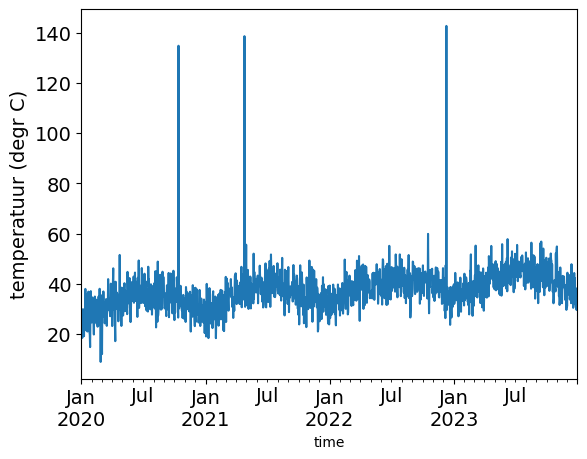

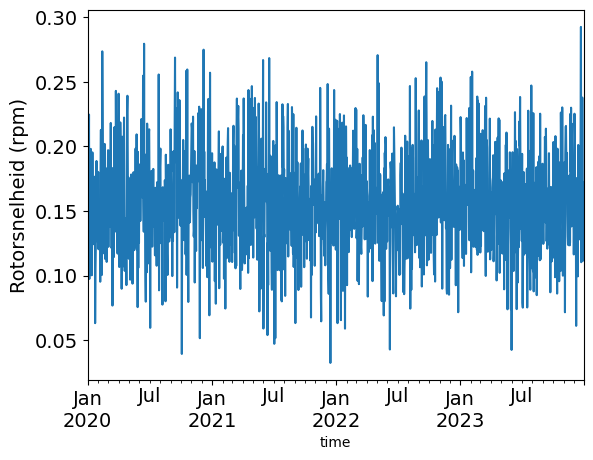

In [22]:
data.index = pd.to_datetime(data["time"]) # zet de tijdskolom om naar een datetime-index
data = data.drop(columns="time") # verwijder de tijdskolom
fig, ax = plt.subplots()
fs = 14
data["temperature (degr C)"].plot()
plt.ylabel("temperatuur (degr C)", fontsize=fs)
plt.tick_params(axis='both', which='both', labelsize=fs)
fig, ax = plt.subplots()
data["rotor_speed (rpm)"].plot()
plt.ylabel("Rotorsnelheid (rpm)", fontsize=fs)
plt.tick_params(axis='both', which='both', labelsize=fs)


## Preprocessing

Wat we zien is dat er in de temperatuursmetingen 3 waarden zitten die ver boven de rest uitschieten. De context is hier de temperatuur van een hoofdlager in een windturbine. Deze waarden zijn fysisch niet mogelijk, dus zijn waarschijnlijk registratie/captatiefouten. Nadat gecontroleerd is dat deze waarden geen nuttige informatie bevatten, moeten ze uit de dataset verwijderd worden. Dit gebeurt typisch in de preprocessing stap.

De rotor speed ziet er oke uit. 

Naast het verwijderen van garbage data, zijn andere zaken die in deze stap gebeuren :
- Resampling : gemiddeldes nemen over vaste intervallen, bijvoorbeeld per dag, per week of per maand. Dit kan voor andere toepassing ook per uur, 10min, min,... Alles hangt hier af van de context en hoe snel-varierend je grootheden zijn en welke tijdsresolutie gewenst is. 
- Identificeren van nuttige data: in deze context is het bijvoorbeeld interessant om enkel data te nemen wanneer de windmolen actief is en dus energie aan het produceren is. Data van een stilstaande windmolen geeft ons niet voor alle doeleinde nuttige informatie. Data captatie tijdens stilstand kan dus ook vaak verwijderd worden.


In [23]:
# verwijder de outliers, die boven de 80 graden zijn
data = data[data["temperature (degr C)"] < 80] 
data = data[data["temperature2 (degr C)"] < 80]

# verwijder de rijen met missende waarden
data.dropna(inplace=True) 

# resample de data naar maandelijkse gemiddelden
data_maand = data.resample("1M").mean(numeric_only=True) 

Plot opnieuw ter controle

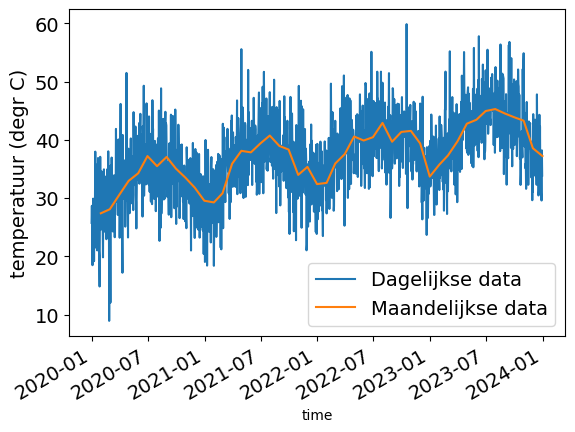

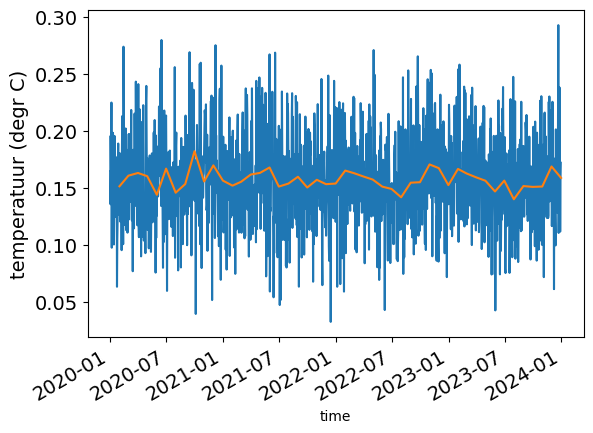

In [24]:
fs = 14
data["temperature (degr C)"].plot(label="Dagelijkse data")
data_maand["temperature (degr C)"].plot(label="Maandelijkse data")
plt.legend(fontsize=fs)
plt.ylabel("temperatuur (degr C)", fontsize=fs)
plt.tick_params(axis='both', which='both', labelsize=fs)

fig, ax = plt.subplots()
fs = 14
data["rotor_speed (rpm)"].plot(label="Dagelijkse data")
data_maand["rotor_speed (rpm)"].plot(label="Maandelijkse data")
plt.ylabel("temperatuur (degr C)", fontsize=fs)
plt.tick_params(axis='both', which='both', labelsize=fs)


Het is een goed idee om de opgekuiste, nette data op te slaan, zodat je deze stappen niet telkens opnieuw hoeft te doen bij het verder modeleren van deze dataset.

In [25]:
path_to_saved_data = "/workspaces/fortech/data/02_intermediate/data_demo_preprocessed.csv" #de locatie waar je de nette data wilt opslaan
data.to_csv("data_demo_preprocessed.csv") # sla de data op
path_to_saved_data_month = "data_demo_preprocessed_monthly.csv" #de locatie waar je de maandgemiddeldes wilt opslaan 
data_maand.to_csv(path_to_saved_data_month) # sla de maandgemiddeldes op

## Data analyse

Normaal volgt nu de stap waarin je de verschillende signalen (tijdseries) bekijkt, vergelijkt, de onderlinge correlaties bekijkt, enzoverder. Om de demo simpel te houden heb ik echter maar 1 feature voorzien, nl. de rotor speed. Uit mijn onderzoek bleek dat er een significante correlatie aanwezig is tussen de rotor speed en de temperatuur. Deze stap wordt doorgaans feature selection genoemd.

Doordat de data artificieel gegenereerd is, is er hier in dit voorbeeld geen lineaire correlatie aanwezig. In de oorspronkelijke dataset was hier wel een significante correlatie. Voor de volledigheid geef ik toch mee hoe dit berekend en gevisualiseerd kan worden.

Belangrijk op te merken is dat deze methode enkel *lineaire* correlatie berekend. Indien het verband tussen twee variabelen exponentieel of kwadratisch zou zijn, kan deze maat voor lineaire correlatie heel klein zijn, terwijl er eigenlijk wel correlatie aanwezig is. Wees dus altijd kritisch!

<Axes: >

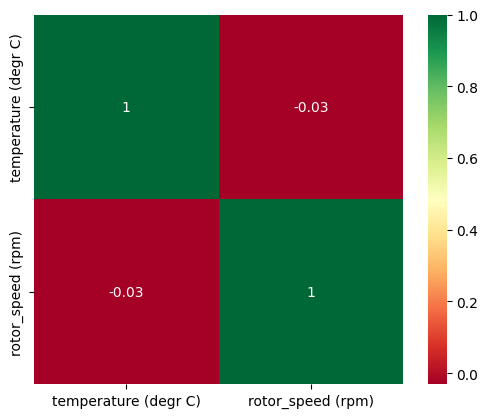

In [26]:
corr = data[["temperature (degr C)", "rotor_speed (rpm)"]].corr(numeric_only=True) # bereken de correlatie tussen de variabelen
sns.heatmap(
    corr, mask=np.zeros_like(corr, dtype=bool), cmap="RdYlGn", annot=True, square=True
)

## Anomaly detectie door middel van clustering

Het doel is om de punten temperatuur vs rotor speed te clusteren, zodat we het "meest voorkomende" gedrag kunnen onderscheiden van afwijkend gedrag.
Laten we dit ons eerst eens visuaal voorstellen.

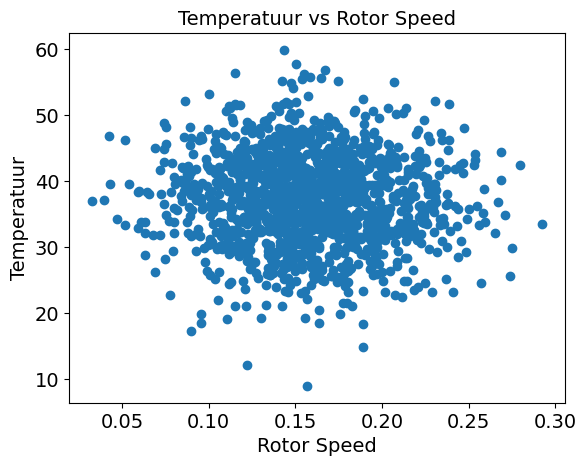

In [27]:
fig, ax1 = plt.subplots()
fs = 14
ax1.scatter(data["rotor_speed (rpm)"], data["temperature (degr C)"])
ax1.set_xlabel('Rotor Speed', fontsize=fs)
ax1.set_ylabel('Temperatuur', fontsize=fs)
plt.title('Temperatuur vs Rotor Speed', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

Het is belangrijk om de data te normaliseren vooraleer we clustering toepassen. Zeker hier in dit geval zie je dat de schaal van de temperatuur een heel stuk groter is dan deze van de rotor speed. 

In [28]:
x = data[["temperature (degr C)", "rotor_speed (rpm)"]].values

# scaler = StandardScaler()
scaler = MinMaxScaler()

x = scaler.fit_transform(x)

Nu passen we hier DBSCAN op toe. Dit staat voor Density-Based Spatial Clustering of Applications with Noise. In tegenstelling tot traditionele clustering algoritmes, moet hier vooraf niet bepaald worden hoeveel clusters er gevonden moeten worden en zal deze dus clusters identificeren van arbitraite groottes. Het algoritme groepeert punten die dicht bij elkaar liggen gebaseerd op de dichtheid. 

Het algoritme heeft twee parameters:  
- eps : definieert de straal rondom ieder datapunt waarin het algoritme een ander punt als een punt in de buurt zal beschouwen.
- min_samples : het minimum aantal punten nodig om een regio als *dense* te beschouwen.

In [29]:
db = DBSCAN(eps=0.1, min_samples=10).fit(x)
labels = db.labels_

# Het aantal clusters is het aantal unieke labels, min 1 als er -1 in de labels zit. -1 staat gelijk aan noise.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Voeg de cluster labels toe aan de data
data["cluster"] = labels

Estimated number of clusters: 1
Estimated number of noise points: 6


Er werd 1 cluster gedetecteerd waarbij er 5 uitschieters (dus anomalien) aanwezig zijn. Dit is ook wat ik artificieel in de data heb gestoken. Het werkt!
Laten we de resultaten even plotten.

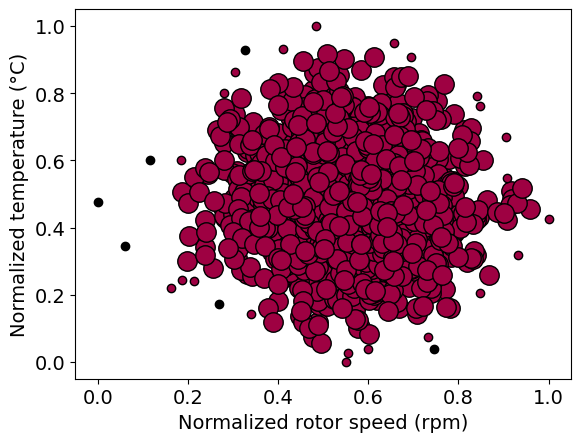

In [30]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.xlabel("Normalized rotor speed (rpm)", fontsize=fs)
plt.ylabel("Normalized temperature (°C)", fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.show()

Nu is het interessant om deze uitschieters wat beter te bestuderen. Daarom plotten we deze even apart in functie van de tijd.

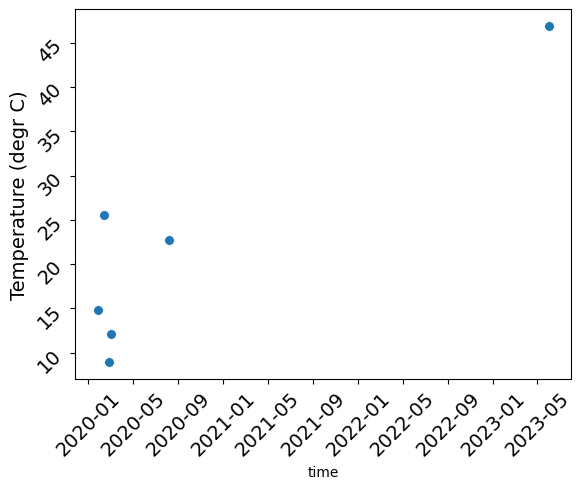

In [31]:
results = data[data["cluster"] == -1]
fig, ax = plt.subplots()
sns.scatterplot(
    data=results, x=results.index, y="temperature (degr C)", s=50)
ax.set_ylabel("Temperature (degr C)", fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=fs, rotation=45)

Deze lijken voornamelijk random verspreid, dus dit wijst niet op een cummulatief, groeiend probleem.

### Toenemende afwijking 

Nu we vertrouwd zijn met het algoritme en de data opgekuist is, kunnen we beginnen met het initiele doel: het vroegtijdig opsporen van afwijkend gedrag dat toeneemt. Hiervoor gaf ik het signaal "temperature2 (degr C)" mee.  

Wanneer we dit signaal plotten, zien we dat er gedurende een paar maanden in 2021 een probleem leek op te treden.

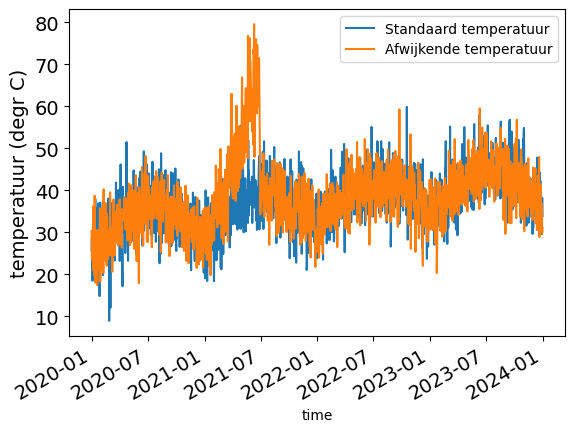

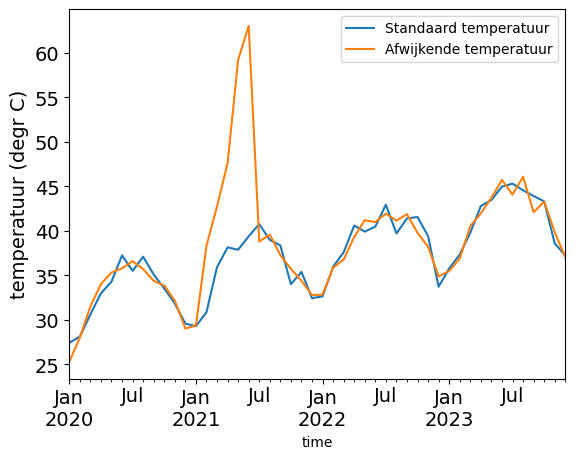

In [32]:
# plot de temperatuur van de afwijkende data en de standaard data voor daggemiddeldes
fig, ax = plt.subplots()
fs = 14
data["temperature (degr C)"].plot(label="Standaard temperatuur")
data["temperature2 (degr C)"].plot(label="Afwijkende temperatuur")
plt.legend()
plt.ylabel("temperatuur (degr C)", fontsize=fs)
plt.tick_params(axis='both', which='both', labelsize=fs)

# plot ook eens maandgemiddeldes
fig, ax = plt.subplots()
fs = 14
data_maand["temperature (degr C)"].plot(label="Standaard temperatuur")
data_maand["temperature2 (degr C)"].plot(label="Afwijkende temperatuur")
plt.legend()
plt.ylabel("temperatuur (degr C)", fontsize=fs)
plt.tick_params(axis='both', which='both', labelsize=fs)

Herhaal het volledige clusterproces op temperature2 nu. 

Estimated number of clusters: 1
Estimated number of noise points: 21


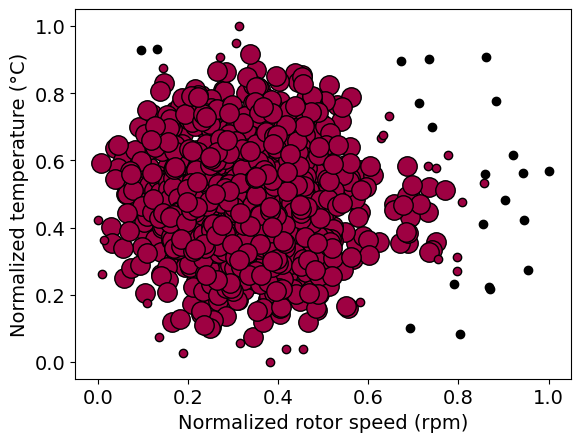

In [33]:
# scaling van de data
x = data[["temperature2 (degr C)", "rotor_speed (rpm)"]].values
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# cluster
db = DBSCAN(eps=0.1, min_samples=10).fit(x)
labels = db.labels_

# Het aantal clusters is het aantal unieke labels, min 1 als er -1 in de labels zit. -1 staat gelijk aan noise.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Voeg de cluster labels toe aan de data
data["cluster"] = labels

# plot
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.xlabel("Normalized rotor speed (rpm)", fontsize=fs)
plt.ylabel("Normalized temperature (°C)", fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.show()

Er zijn al heel wat meer uitschieters gedetecteerd. Laten we deze even beter bekijken. 

(18748.0, 18840.0)

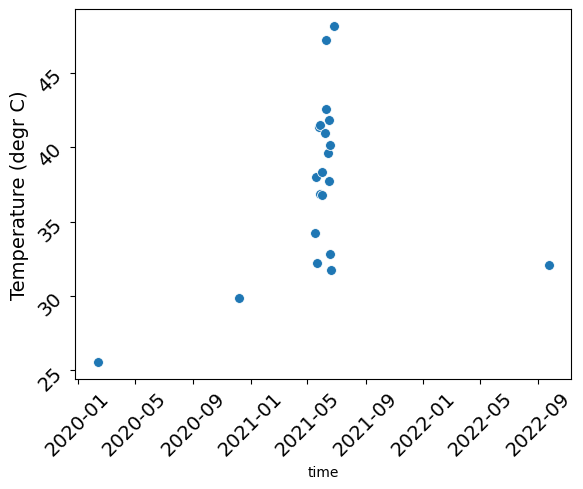

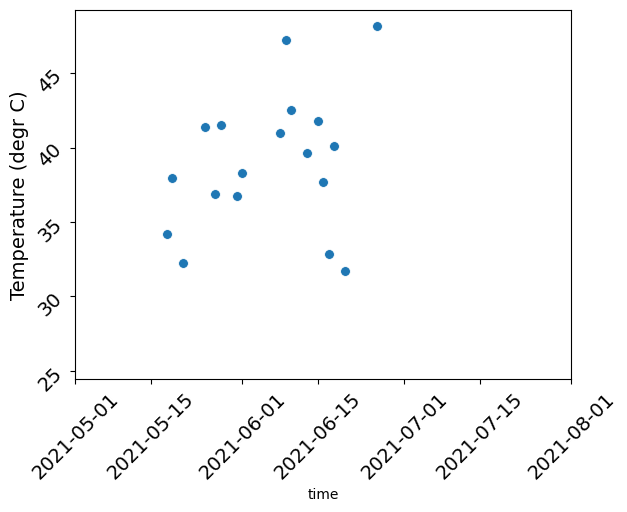

In [34]:
results = data[data["cluster"] == -1]
fig, ax = plt.subplots()
sns.scatterplot(
    data=results, x=results.index, y="temperature (degr C)", s=50)
ax.set_ylabel("Temperature (degr C)", fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=fs, rotation=45)

results = data[data["cluster"] == -1]
fig, ax = plt.subplots()
sns.scatterplot(
    data=results, x=results.index, y="temperature (degr C)", s=50)
ax.set_ylabel("Temperature (degr C)", fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=fs, rotation=45)
plt.xlim(dt.datetime(2021,5,1), dt.datetime(2021,8,1))

Het valt op dat er iets mis was tussen de periode 2021-5-15 en 2021-07-01. Daar treden de uitschieters vooral op en ze lijken ook te stijgen in de tijd. Nu weet ik zelf wanneer ik het defect laten starten heb, en is dit reeds gestart 2021-01-01. Het duurt dus 5 maanden vooraleer het gedetecteerd wordt hier en 2 maanden later moet de molen al stilgelegd worden. Dit moet beter kunnen! 

Daarnaast is deze methode ook niet voordelig wanneer er nieuwe data moet geanalyseerd worden. De hele dataset moet dan opnieuw opgeladen worden om deze nieuwe punten in te delen.

Het werkt dus goed als er enkele punten anomalisch zijn, maar niet wanneer een opbouwende afwijking vroegtijdig gedetecteerd moet worden. Weer wat wijzer!

## Anomalie detectie door middel van autoencoders

Laten we eens een nieuwe strategie proberen toe te passen. Aangezien we een ander model gebruik, zal de data een beetje anders moeten voorbereid worden. Vandaar is het veiliger de nette opgekuiste data die we tussendaar opgeslagen hebben hier opnieuw in te laden.

In [35]:
data = pd.read_csv(path_to_saved_data)

Een autoencoder is een bepaalde type neuraal netwerk dat vaak gebruikt wordt voor unsupervised learning. Het zal de data eerst via een encoder omzetten naar een representatie van lagere dimensie. Het decoder gedeelte zal deze dan terug reconstrueren naar de originele representatie van de data. 

De redenering is dat wanneer deze autoencoder een netwerk getraind heeft op goeie data van de windmolens en dan opeens gevoed wordt met data die zich anders gedraagt, dan zal het algoritme niet in staat zijn het originele signaal te reconstrueren. Op deze manier detecteren we dan dat het signaal anomalisch was. 